# **Занятие 2.**

# [Pytorch autograd](https://pytorch.org/docs/stable/autograd.html)

[Tutorial](https://www.youtube.com/watch?v=MswxJw-8PvE)

[Slides](https://app.diagrams.net/#G1bq3akhmA5DGRCiFYJfNPSn7il2wvCkEY)

[Torch C++ Binary operations](https://github.com/pytorch/pytorch/blob/c5872e6d6d8fd9b8439b914c143d49488335f573/aten/src/ATen/native/cpu/BinaryOpsKernel.cpp)

[Torch C++ Activations](https://github.com/pytorch/pytorch/blob/c5872e6d6d8fd9b8439b914c143d49488335f573/aten/src/ATen/native/cpu/Activation.cpp)

In [ ]:
import torch

In [ ]:
def show_tensor_params(*tensors):
  for x in tensors:
    print('---')
    print(f"data - {x.data}")
    print(f"grad - {x.grad}")
    print(f"grad_fn - {x.grad_fn}")
    print(f"req_grad - {x.requires_grad}")
    print(f"is_leaf - {x.is_leaf}")

In [ ]:
x = torch.tensor(5.0)
show_tensor_params(x)

---
data - 5.0
grad - None
grad_fn - None
req_grad - False
is_leaf - True


All Tensors that have **requires_grad** which is **False** will be leaf Tensors by convention.

For Tensors that have **requires_grad** which is **True**, they will be leaf Tensors if they were created by the user. This means that they are not the result of an operation and so **grad_fn** is None.

Only leaf Tensors will have their **grad** populated during a call to backward(). To get grad populated for non-leaf Tensors, you can use retain_grad().[[Link]](https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html#torch.Tensor.is_leaf)

In [ ]:
#Slide A4
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0)
c = a*b

c.backward()
# (2 * c).backward()

In [ ]:
show_tensor_params(a, b, c)

---
data - 2.0
grad - 3.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 3.0
grad - None
grad_fn - None
req_grad - False
is_leaf - True
---
data - 6.0
grad - None
grad_fn - <MulBackward0 object at 0x7fbee0481c70>
req_grad - True
is_leaf - False


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


In [ ]:
#Slide Simple5

In [ ]:
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = a*b
d = torch.tensor(4.0, requires_grad=True)
e = c*d

# c.retain_grad()
# e.retain_grad()
e.backward()

In [ ]:
show_tensor_params(a, b, c, d, e)

---
data - 2.0
grad - 12.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 3.0
grad - 8.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 6.0
grad - None
grad_fn - <MulBackward0 object at 0x7fbe6ef85670>
req_grad - True
is_leaf - False
---
data - 4.0
grad - 6.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 24.0
grad - None
grad_fn - <MulBackward0 object at 0x7fbe6eff7d90>
req_grad - True
is_leaf - False


In [ ]:
#In place 1
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = a*b
d = torch.tensor(4.0, requires_grad=True)
e = c*d
c += 1

e.backward()

RuntimeError: ignored

In [ ]:
print(c._version)
print(d._version)

1
0


In [ ]:
#In place 2
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = a*b
d = torch.tensor(4.0, requires_grad=True)
e = c+d
c += 1

e.backward()

In [ ]:
print(c._version)
print(d._version)

1
0


In [ ]:
# отвязка от графа
k = e.detach()

In [ ]:
k.storage == e.storage

False

In [ ]:
show_tensor_params(e, k)

---
data - 10.0
grad - None
grad_fn - <AddBackward0 object at 0x7fbe6ef85e80>
req_grad - True
is_leaf - False
---
data - 10.0
grad - None
grad_fn - None
req_grad - False
is_leaf - True


# Создание собственной библиотеки автоматического дифференцирования

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Простой пример

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

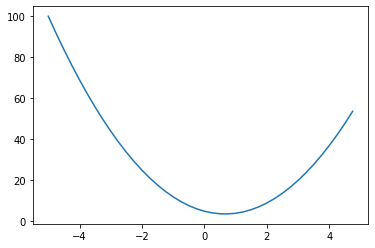

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.000001
x = 2
(f(x + h) - f(x))/h

8.000003001384925

### Более сложный пример

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


https://pytorch.org/tutorials/beginner/examples_autograd/polynomial_custom_function.html

In [ ]:
import torch
from torch.autograd import Function

In [ ]:
class Exp(Function):
  """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

  @staticmethod
  def forward(ctx, i):
    """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
    """
    result = i.exp()
    ctx.save_for_backward(result)
    return result

  @staticmethod
  def backward(ctx, grad_output):
    """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
    """
    print(ctx.saved_tensors)
    result, = ctx.saved_tensors
    return grad_output * result

In [ ]:
# Use it by calling the apply method
input = torch.tensor(2.0, requires_grad=True)
output = Exp.apply(input)
output

tensor(7.3891, grad_fn=<ExpBackward>)

In [ ]:
import math
math.exp(2.0)

7.38905609893065

In [ ]:
output.backward()
show_tensor_params(output)
show_tensor_params(input)

(tensor(7.3891, grad_fn=<ExpBackward>),)
---
data - 7.389056205749512
grad - None
grad_fn - <torch.autograd.function.ExpBackward object at 0x7f82e5540040>
req_grad - True
is_leaf - False
---
data - 2.0
grad - 7.389056205749512
grad_fn - None
req_grad - True
is_leaf - True


<ipython-input-17-168b1ceafb31>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  print(f"grad - {x.grad}")


**Задание**: реализуйте backward для Polynomial 0.5 * (5 * input ** 3 - 3 * input)

In [ ]:
import torch


class Polynomial(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        result = 2.5 * input**3 - 1.5 * input
        ctx.save_for_backward(input)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input = ctx.saved_tensors[0]
        result = 7.5 * input**2 - 1.5
        return grad_output * result

In [ ]:
# Use it by calling the apply method
input = torch.tensor(2.0, requires_grad=True)
output = Polynomial.apply(input)
output

tensor(17., grad_fn=<PolynomialBackward>)

In [ ]:
0.5 * (5 * 2**3 - 3*2)

17.0

In [ ]:
output.backward()
show_tensor_params(output)
show_tensor_params(input)

---
data - 17.0
grad - None
grad_fn - <torch.autograd.function.PolynomialBackward object at 0x7f82e5540400>
req_grad - True
is_leaf - False
---
data - 2.0
grad - 28.5
grad_fn - None
req_grad - True
is_leaf - True


<ipython-input-17-168b1ceafb31>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  print(f"grad - {x.grad}")


In [ ]:
7.5 * 2**2 - 1.5

28.5

Практическое задание: написать собственный движок автоматического дифференцирования, а именно: реализовать

In [ ]:
from typing import Union


class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data: Union[int, float], _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None # function 
        self._prev = set(_children) # set of Value objects
        self._op = _op # the op that produced this node, string ('+', '-', ....)

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data + other.data,
            _children=(self, other),
            _op='+',
        )

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data * other.data,
            _children=(self, other),
            _op='*',
        )

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(
            data=self.data ** other,
            _children=(self,),
            _op='^',
        )

        def _backward():
            self.grad += out.grad * other * self.data**(other-1)
        out._backward = _backward

        return out

    def relu(self):
        out = Value(
            data=self.data if self.data > 0 else 0,
            _children=(self,),
            _op='relu'
        )

        def _backward():
            self.grad += out.grad * int(self.data > 0)
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                print(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [ ]:
def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    print(xmg, xpt, xpt.grad)
    assert xmg.grad == xpt.grad.item()


def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

In [ ]:
a = Value(-4.0)
b = Value(2.0)
d = Value(3.0)

In [ ]:
c = a + b
e = c * d
e.backward()

Value(data=-6.0, grad=0)
Value(data=-2.0, grad=0)
Value(data=-4.0, grad=0)
Value(data=2.0, grad=0)
Value(data=3.0, grad=0)


In [ ]:
test_sanity_check()

Value(data=-20.0, grad=0)
Value(data=-160.0, grad=0)
Value(data=40.0, grad=0)
Value(data=40.0, grad=0)
Value(data=-10.0, grad=0)
Value(data=-4.0, grad=0)
Value(data=-6.0, grad=0)
Value(data=-8.0, grad=0)
Value(data=2, grad=0)
Value(data=2, grad=0)
Value(data=0, grad=0)
Value(data=140.0, grad=0)
Value(data=100.0, grad=0)
Value(data=100.0, grad=0)
Value(data=-4.0, grad=46.0) tensor([-4.], dtype=torch.float64, requires_grad=True) tensor([46.], dtype=torch.float64)


In [ ]:
test_more_ops()

Value(data=24.70408163265306, grad=0)
Value(data=24.5, grad=0)
Value(data=0.5, grad=0)
Value(data=49.0, grad=0)
Value(data=-7.0, grad=0)
Value(data=-1.0, grad=0)
Value(data=2.0, grad=0)
Value(data=-2.0, grad=0)
Value(data=1, grad=0)
Value(data=-3.0, grad=0)
Value(data=-1.0, grad=0)
Value(data=1, grad=0)
Value(data=-2.0, grad=0)
Value(data=-4.0, grad=0)
Value(data=2.0, grad=0)
Value(data=4.0, grad=0)
Value(data=-1, grad=0)
Value(data=-6.0, grad=0)
Value(data=6.0, grad=0)
Value(data=6.0, grad=0)
Value(data=6.0, grad=0)
Value(data=6.0, grad=0)
Value(data=4.0, grad=0)
Value(data=-1, grad=0)
Value(data=0.0, grad=0)
Value(data=3, grad=0)
Value(data=0.0, grad=0)
Value(data=0.0, grad=0)
Value(data=-8.0, grad=0)
Value(data=8.0, grad=0)
Value(data=0.0, grad=0)
Value(data=0.0, grad=0)
Value(data=2, grad=0)
Value(data=0, grad=0)
Value(data=-2.0, grad=0)
Value(data=-1, grad=0)
Value(data=0.2040816326530612, grad=0)
Value(data=10.0, grad=0)
Value(data=0.02040816326530612, grad=0)
